IMPORTS

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

VGG MODEL STRUCTURE

In [2]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

DATA PREPROCESSING

In [3]:

venomous_classes = ["barredcoral snake", "king cobra", "north ph temple pitviper"]

def csv_to_binary_labels(csv_path, image_dir):
    df = pd.read_csv(csv_path)

    class_cols = df.columns[1:]  # skip filename
    df["label"] = df[class_cols].idxmax(axis=1)

    df["binary_label"] = df["label"].apply(lambda x: 1 if x in venomous_classes else 0)

    # Create the final binary DataFrame
    df_binary = df[["filename", "binary_label"]].copy()
    df_binary["filename"] = df_binary["filename"].apply(lambda x: f"{image_dir}/{x}")

    # ✅ Make sure labels are strings for class_mode='binary'
    df_binary["binary_label"] = df_binary["binary_label"].astype(str)

    return df_binary

DATA AUGMENTATION

In [4]:

# Image size and batch size
img_size = (224, 224)
batch_size = 16

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess_input)

TRAIN AND VALIDATION DATAFRAME GENERATION

In [5]:

datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess_input)

train_df = csv_to_binary_labels("../dataset/train/_classes.csv", "../dataset/train")
val_df   = csv_to_binary_labels("../dataset/valid/_classes.csv", "../dataset/valid")

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",  # gives [0] or [1] directly
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)



Found 6176 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.


DEFINE CLASS WEIGHTS

In [6]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['binary_label']),
    y=train_df['binary_label']
)
class_weights = dict(enumerate(class_weights))

MODEL TRAINING

In [7]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10


c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


386/386 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - accuracy: 0.5637 - loss: 0.7258 - precision: 0.5875 - recall: 0.5715 - val_accuracy: 0.7296 - val_loss: 0.5180 - val_precision: 0.7373 - val_recall: 0.7532
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.7831 - loss: 0.4574 - precision: 0.7805 - recall: 0.8212 - val_accuracy: 0.8507 - val_loss: 0.3364 - val_precision: 0.8340 - val_recall: 0.8933
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.8900 - loss: 0.2508 - precision: 0.8812 - recall: 0.9124 - val_accuracy: 0.8976 - val_loss: 0.2434 - val_precision: 0.8716 - val_recall: 0.9440
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.9508 - loss: 0.1342 - precision: 0.9434 - recall: 0.9645 - val_accuracy: 0.9310 - val_loss: 0.1775 - val_precision: 0.9030 - val_recall: 0.9731
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9646 - loss: 0.0968 - precision: 0.9592 - recall: 0.9736 - val_accuracy: 0.9321 - val_loss: 0.2705 -

In [8]:
# Save the trained model
model.save('vgg16_finetuned_model.h5')  # Save the entire model
print("Model saved successfully as vgg16_finetuned_model.h5")

Model saved successfully as vgg16_finetuned_model.h5


SAVING THE MODEL FOR ENSEMBLING

In [9]:
test_df  = csv_to_binary_labels("../dataset/test/_classes.csv", "../dataset/test") 

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

Found 1334 validated image filenames belonging to 2 classes.


DATA VALIDATION METRICS

In [10]:
# Evaluate the Model on Validation Data
validation_scores = model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(validation_scores[1] * 100))
print("Validation Precision: {:.2f}%".format(validation_scores[2] * 100))
print("Validation Recall: {:.2f}%".format(validation_scores[3] * 100))

111/111 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9401 - loss: 0.2234 - precision: 0.9688 - recall: 0.9137
Validation Accuracy: 94.17%
Validation Precision: 97.58%
Validation Recall: 91.16%


DATA TEST METRICS

In [11]:
# Evaluate the Model on Test Data
test_scores = model.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_scores[1] * 100))
print("Test Precision: {:.2f}%".format(test_scores[2] * 100))
print("Test Recall: {:.2f}%".format(test_scores[3] * 100))

c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8332 - loss: 3.0615 - precision: 0.9150 - recall: 0.7442
Test Accuracy: 81.33%
Test Precision: 89.73%
Test Recall: 70.76%


GENERATING PREDICTIONS

In [15]:
# Generate predictions
test_generator.reset()
y_pred = model.predict(test_generator).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_df["binary_label"].values
y_true = [int(label) for label in y_true]

84/84 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step


VGG16 TEST DATA CONFUSION MATRIX

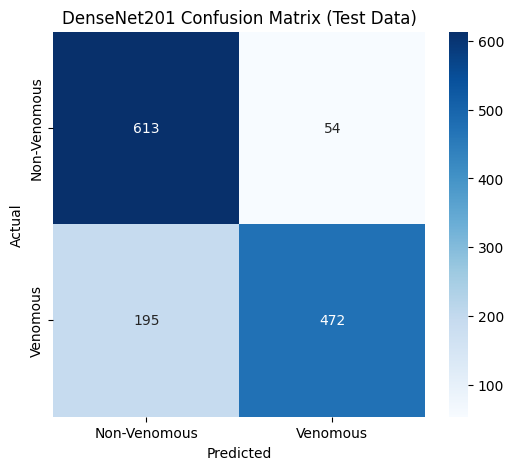

In [ ]:
# Confusion Matrix for Test Data
cm_test = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Venomous", "Venomous"],
            yticklabels=["Non-Venomous", "Venomous"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('VGG16 Confusion Matrix (Test Data)')
plt.show()